In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import aux_funcs
from pathlib import Path

## Collect data from 3 different containers

30: entropy shuffle (split)

0: zstd shuffle split

1: zlib shuffle split

2: lz4hc shuffle split

In [16]:
paths = [Path('../data_inputs_temp/'),
         Path('../data_inputs'),
         Path('../data_inputs_wind/')]

files = ['entropy-shuffle', 'zstd-shuffle-split', 'zlib-shuffle-split',
         'lz4hc-shuffle-split']
categories = ["30"] + [str(i) for i in range(len(files) - 1)]

df_entropy = aux_funcs.get_df_by_category(paths, files[0], categories[0])
df_zstd = aux_funcs.get_df_by_category(paths, files[1], categories[1])
df_zlib = aux_funcs.get_df_by_category(paths, files[2], categories[2])
df_lz4hc= aux_funcs.get_df_by_category(paths, files[3], categories[3])

# Filter data

Delete data corresponding to special values chunks.

In [17]:
df_shuffle = pd.concat([df_zstd, df_zlib, df_lz4hc, df_entropy], axis=1)
df_shuffle = aux_funcs.delete_special_vals(df_shuffle, ["special_vals0", "special_vals1", "special_vals2", "special_vals30"])
df_input_x = df_shuffle.iloc[:, [9, 10]]

## Compute best category

In [18]:
df_codecs = df_shuffle.drop(['cratio30', 'speed30', 'special_vals30',
                             'special_vals0', 'special_vals1', 'special_vals2'], axis=1)

### Normalize cratio and speed

In [19]:
dfcratios = pd.concat([df_codecs.iloc[:, 0], df_codecs.iloc[:, 2],
                       df_codecs.iloc[:, 4]], axis=0)
mean_cratio = dfcratios.mean()

cratio0 = df_codecs["cratio0"]
cratio1 = df_codecs["cratio1"]
cratio2 = df_codecs["cratio2"]

ncratio0 = cratio0 - mean_cratio
ncratio1 = cratio1 - mean_cratio
ncratio2 = cratio2 - mean_cratio

all_cratios = np.concatenate((ncratio0, ncratio1, ncratio2), axis=0)

std_cratio = all_cratios.std()
ncratio0 /= std_cratio
ncratio1 /= std_cratio
ncratio2 /= std_cratio

In [20]:
dfspeeds = pd.concat([df_codecs.iloc[:, 1], df_codecs.iloc[:, 3],
                      df_codecs.iloc[:, 5]], axis=0)
mean_speed = dfspeeds.mean()

speed0 = df_codecs["speed0"]
speed1 = df_codecs["speed1"]
speed2 = df_codecs["speed2"]

nspeed0 = speed0 - mean_speed
nspeed1 = speed1 - mean_speed
nspeed2 = speed2 - mean_speed

all_speeds = np.concatenate((nspeed0, nspeed1, nspeed2), axis=0)

dsv_speed = all_speeds.std()
nspeed0 /= dsv_speed
nspeed1 /= dsv_speed
nspeed2 /= dsv_speed

### Compute score to determine which category is the best one

In [21]:
theta = 0.96

df_score = pd.DataFrame()
df_score.insert(0, 0, theta*ncratio0 + (1-theta)*nspeed0)
df_score.insert(1, 1, theta*ncratio1 + (1-theta)*nspeed1)
df_score.insert(2, 2, theta*ncratio2 + (1-theta)*nspeed2)

In [22]:
best_categ_shuffle = pd.DataFrame(df_score.idxmax(axis=1), columns=['best_categ'])

In [23]:
categories = best_categ_shuffle['best_categ'].unique()
if len(categories) < (len(files) - 1):
    raise ValueError("Not enough categories in training data")

In [24]:
df_t = pd.DataFrame()
df_t = pd.concat([df_t, df_input_x['cratio30']], axis=1)
df_t = pd.concat([df_t, df_input_x['speed30']], axis=1)
df_t = pd.concat([df_t, best_categ_shuffle], axis=1)

Balance data

In [25]:
df_blc = pd.DataFrame()
for i in categories:
    df_i = df_t[df_t['best_categ'] == i]
    df_i = df_i.head(n=9618)
    df_blc = pd.concat([df_blc, df_i], axis=0)

In [26]:
dfinput_y = pd.DataFrame()
dfinput_y = pd.concat([dfinput_y, df_blc['best_categ']], axis = 1)

In [27]:
dfinput_x = df_blc.drop(['best_categ'], axis = 1)

## Normalize entropy data

In [28]:
dfcratios = pd.concat([dfinput_x.iloc[:, 0]], axis=0)
desv_cratio = dfcratios.std()
mean_cratio = dfcratios.mean()

cratio = dfinput_x["cratio30"]
ncratio = (cratio - mean_cratio) / desv_cratio

In [29]:
dfspeeds = pd.concat([dfinput_x.iloc[:, 1]], axis=0)
mean_speed = dfspeeds.mean()
desv_speed = dfspeeds.std()

speed = dfinput_x["speed30"]
nspeed = (speed - mean_speed) / desv_speed

dfinput_x_norm = pd.DataFrame()
dfinput_x_norm.insert(0, "ncratio", ncratio)
dfinput_x_norm.insert(1, "nspeed", nspeed)

dfinput_x = dfinput_x_norm

# Neural Network with 3 categories


In [30]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_test, y_train, y_test = train_test_split(dfinput_x, dfinput_y, test_size=0.1, shuffle=True)

In [31]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

2023-01-03 11:20:23.376012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Build model

In [32]:
from keras import models, layers
import tensorflow

tensorflow.random.set_seed(100)

model = models.Sequential()
model.add(layers.Dense(2, activation='relu', input_shape=(2,)))
model.add(layers.Dense(2, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

2023-01-03 11:20:35.293446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

## Train it with data

In [37]:
history = model.fit(x_train, y_train, epochs = 60, validation_data = (x_test, y_test))

Epoch 1/60
812/812 [==============================] - 3s 2ms/step - loss: 1.0996 - acc: 0.3002 - val_loss: 1.0885 - val_acc: 0.3361

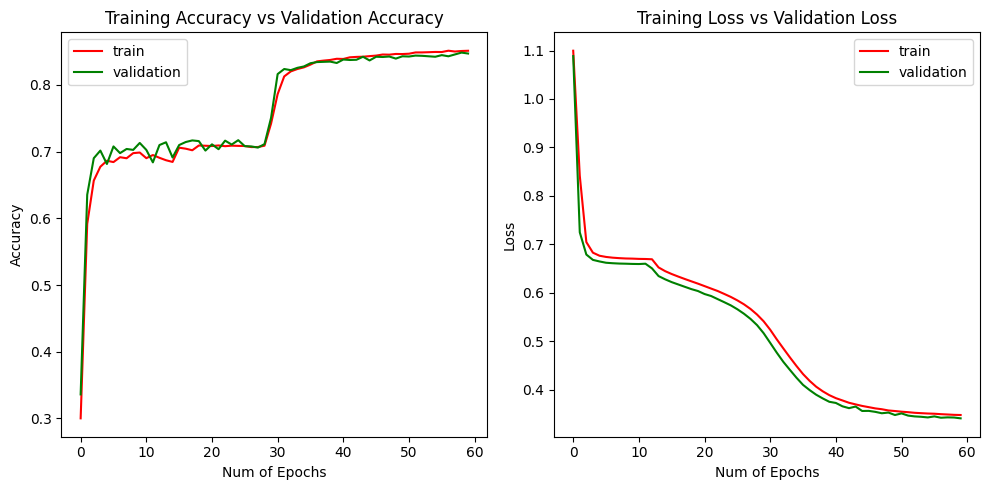

In [38]:
_, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
ax[0].plot(history.history['acc'], 'r')
ax[0].plot(history.history['val_acc'], 'g')
ax[0].set_xlabel("Num of Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Training Accuracy vs Validation Accuracy")
ax[0].legend(['train', 'validation'])

ax[1].plot(history.history['loss'], 'r')
ax[1].plot(history.history['val_loss'], 'g')
ax[1].set_xlabel("Num of Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_title("Training Loss vs Validation Loss")
ax[1].legend(['train', 'validation'])

plt.tight_layout()

## Test it

### Rebuild model

Rebuild model until epoch x.

In [39]:
# model = models.Sequential()
# model.add(layers.Dense(2, activation='relu', input_shape=(2,)))
# model.add(layers.Dense(2, activation='relu'))
# model.add(layers.Dense(3, activation='softmax'))
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['acc'])
# history = model.fit(x_train, y_train, epochs=x, validation_data = (x_test, y_test))

### Predict train data

In [40]:
y_hat = model.predict(x=x_train)
y_pred_label = np.argmax(y_hat, axis=1)
y_true_label = np.argmax(y_train, axis=1)

812/812 [==============================] - 1s 2ms/step

In [41]:
table = pd.crosstab(y_pred_label, y_true_label)
table

col_0,0,1,2
row_0,,,
0,7667,752,435
1,973,6832,584
2,16,1064,7645


In [42]:
(table[0][0] + table[1][1]) / np.sum(table.sum())

0.5583410351201479

### Predict test data

In [43]:
predictions = model.predict(x=x_test)
pred_label = np.argmax(predictions, axis=1)
true_label = np.argmax(y_test, axis=1)

91/91 [==============================] - 0s 1ms/step


In [44]:
table = pd.crosstab(pred_label, true_label)
table

col_0,0,1,2
row_0,,,
0,851,77,49
1,110,756,67
2,1,137,838


In [45]:
aux = np.abs(pred_label - true_label)
fails = np.count_nonzero(aux)

score = (len(aux) - fails) / len(aux)
score



0.8471933471933472